# Collaboration

## Configure environments

In [1]:
# Run this to change the working directory.
# TODO: pip install will resolve this issue...
import os
os.chdir("..")

In [2]:
import numpy as np
import torch
from imagiq.federated.nodes import Node
from imagiq.models import Model
from imagiq.datasets import CBISDDSMDataset, LoadBreastDensity, LoadBreastDensityd
from imagiq.utils.file_systems import remove, mkdir
from monai.transforms import (
    Compose,
    LoadImaged,
    ScaleIntensityd,
    SqueezeDimd,
    AddChanneld,
    AsChannelFirstd,
    Lambdad,
    ToTensord,
    Resized,
    RandRotated,
    RandFlipd,
    RandHistogramShiftd,
    RandGaussianNoised,
    RandZoomd,
    RepeatChanneld, 
    NormalizeIntensityd
)

from monai.data import CacheDataset
import sys
import pandas as pd
import gc

from monai.networks.nets import densenet121, densenet169
from monai.networks.nets.senet import se_resnet50, se_resnet101, se_resnet152

/Users/navya/opt/anaconda3/envs/imagiq-fl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'imagiq'

In [5]:
!pip install torch

     |████████████████████████████████| 129.9 MB 37.3 MB/s eta 0:00:01     |██████████████████████████▉     | 109.0 MB 50.9 MB/s eta 0:00:01


## Load Dataset

In [3]:
# Transformation for breast density dataset
train_transform = Compose( [
    LoadImaged( keys='image'),
    Lambdad(keys='image', func=lambda x: x.T),
    AsChannelFirstd('image'),
    RepeatChanneld('image', repeats=3),
    Resized('image', spatial_size=(225,225), mode='nearest'),
    ScaleIntensityd('image'), # scale data to 0~1
    NormalizeIntensityd( 'image', 
                        subtrahend=[0.485, 0.456, 0.406],
                        divisor=[0.229, 0.224, 0.225], 
                        channel_wise=True), # standardize with ImageNet weights
    RandFlipd('image', spatial_axis=0, prob=0.5), 
    RandZoomd( 'image', min_zoom=0.9, max_zoom=1.5, prob=0.5, keep_size=True),
    ToTensord( ('image', 'label') ),
])

val_transform = Compose( [
    LoadImaged( keys='image'),
    Lambdad(keys='image', func=lambda x: x.T),
    AsChannelFirstd('image'),
    RepeatChanneld('image', repeats=3),
    Resized('image', spatial_size=(225,225), mode='nearest'),
    ScaleIntensityd('image'),
    NormalizeIntensityd( 'image', 
                        subtrahend=[0.485, 0.456, 0.406],
                        divisor=[0.229, 0.224, 0.225], 
                        channel_wise=True), # standardize with ImageNet weights
    ToTensord( ('image', 'label') ),
])


train_ds = CBISDDSMDataset( section='training', transforms=train_transform, download=[0])
val_ds = CBISDDSMDataset( section='validation', transforms=val_transform, download=[0])
test_ds = CBISDDSMDataset( section='test', transforms=val_transform, download=[0])

100%|██████████| 134/134 [00:13<00:00,  9.71it/s]


## Create Node

Share your IP address and port number to your peers to share the models.

In [4]:
localNode = Node( "localhost", port=8000 ) # local server
print( localNode ) 

# If local node is crashed for some reason, you can try to load your Node
# localNode = Node( 'localhost', 8000, node_uid )

node_709de
Node created.
Creating a TCP/IP socket.
Listening at localhost:8000
 Node 709de612094ceab0026b9fa614bd0114

   Name: node_709de

   Host: localhost:8000

   Models: 



## Add Models

In [5]:
denseNet121 = densenet121(
    spatial_dims=2,
    in_channels=3,
    out_channels=4, 
    pretrained=True
)

denseNet121.class_layers = torch.nn.Sequential( 
    torch.nn.ReLU( inplace=True ), 
    torch.nn.AdaptiveAvgPool2d( output_size=1),
    torch.nn.Flatten(start_dim=1, end_dim=-1), 
    torch.nn.Linear(in_features=1024, out_features=4, bias=True),
    torch.nn.Softmax()
)

denseNet169 = densenet169(spatial_dims=2, in_channels=3, out_channels=4, pretrained=True)
denseNet169.class_layers = torch.nn.Sequential( 
    torch.nn.ReLU( inplace=True ), 
    torch.nn.AdaptiveAvgPool2d( output_size=1),
    torch.nn.Flatten(start_dim=1, end_dim=-1), 
    torch.nn.Linear(in_features=1664, out_features=4, bias=True),
    torch.nn.Softmax()
)

resnet50 = se_resnet50( spatial_dims=2, in_channels=3, num_classes=4, pretrained=True)
resnet101 = se_resnet101( spatial_dims=2, in_channels=3, num_classes=4, pretrained=True)
resnet152 = se_resnet152( spatial_dims=2, in_channels=3, num_classes=4, pretrained=True)
resnet50.last_linear = torch.nn.Sequential( 
    torch.nn.Linear( in_features=2048, out_features=4, bias=True ), 
    torch.nn.Softmax()
)
resnet101.last_linear = torch.nn.Sequential( 
    torch.nn.Linear( in_features=2048, out_features=4, bias=True ), 
    torch.nn.Softmax()
)
resnet152.last_linear = torch.nn.Sequential( 
    torch.nn.Linear( in_features=2048, out_features=4, bias=True ), 
    torch.nn.Softmax()
)

In [6]:
# update to your model names
localNode.add_model([
    Model(denseNet121, 'UIowa_denseNet121'), 
    Model(denseNet169, 'UIowa_denseNet169'), 
    Model(resnet50, 'UIowa_resnet50'), 
    Model(resnet101, 'UIowa_resnet101'), 
    Model(resnet152, 'UIowa_resnet152')
])

In [7]:
print(localNode.model_bench) 

[UIowa_denseNet121, UIowa_denseNet169, UIowa_resnet50, UIowa_resnet101, UIowa_resnet152]


## Train models

In [8]:
# helper loss function
def cross_entorpy_with_onehot(input, target):
    _, labels = target.max(dim=1)
    return torch.nn.CrossEntropyLoss()(input, labels)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print( 'device:', device )

# temporary directory to save a snapshot
# update to your local directory
temp_saveSnapshot_dir = '/local/vol00/home/bochoi/tmpModels/' 

histories = [None] * len(localNode.model_bench)
for idx in range( len(localNode.model_bench) ):
    print(localNode.model_bench[idx].name)
    mkdir(temp_saveSnapshot_dir)

    optimizer = torch.optim.Adam( localNode.model_bench[idx].net.parameters(), 5e-5)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode='min', factor=0.1, patience=30)
    histories[idx] = localNode.model_bench[idx].train(
        dataset=train_ds,
        loss_function=cross_entorpy_with_onehot,
        optimizer=optimizer,
        epochs=500,
        metrics=["AUC"],
        batch_size=16,
        device=device,
        validation_dataset=val_ds,
        dirpath=temp_saveSnapshot_dir, 
        earlystop={'patience':50, 'delta':0}, 
    )
    if len( os.listdir( temp_saveSnapshot_dir ) ) != 0:
        localNode.model_bench[idx].load_snapshot(temp_saveSnapshot_dir)
    
    # save model's prediction performance
    _, _ = localNode.model_bench[idx].predict( train_ds, section='train')
    _, _ = localNode.model_bench[idx].predict( val_ds, section='validation')
    _, _ = localNode.model_bench[idx].predict( test_ds, section='test')
    
    # commit the trained model
    localNode.model_bench[idx].commit('initial commit')
    remove(temp_saveSnapshot_dir)
    
    gc.collect()
    torch.cuda.empty_cache()

[]

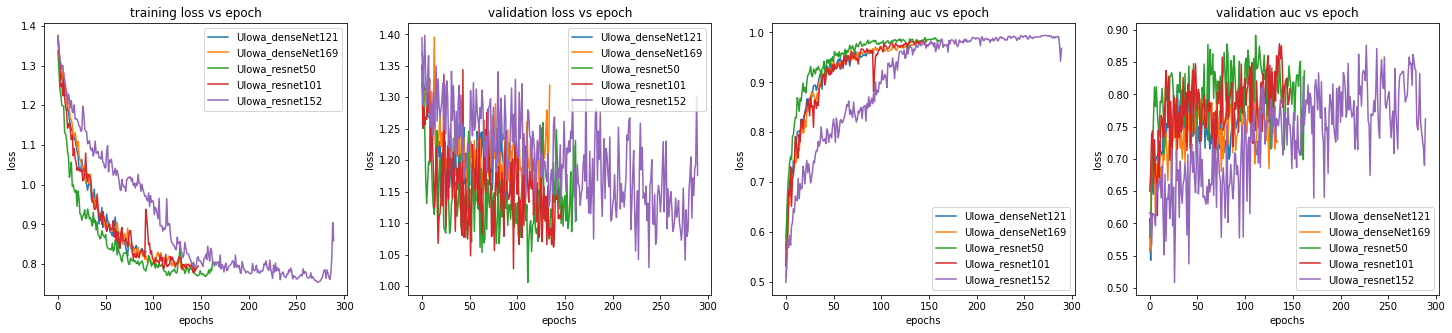

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

cols = 4
plt.figure( figsize=(25, 5) ) 

plt.subplot( 1, cols, 1 )
for model_history in histories:
    plt.plot( model_history['loss'] )
plt.title( 'training loss vs epoch' )
plt.legend( [model.name for model in localNode.model_bench] )
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot( 1, cols, 2 )
for model_history in histories:
    plt.plot( model_history['val_loss'] )
plt.title( 'validation loss vs epoch' )
plt.legend( [model.name for model in localNode.model_bench] )
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot( 1, cols, 3 )
for model_history in histories:
    plt.plot( model_history['auc'] )
plt.title( 'training auc vs epoch' )
plt.legend( [model.name for model in localNode.model_bench] )
plt.xlabel('epochs')
plt.ylabel('loss')

plt.subplot( 1, cols, 4 )
for model_history in histories:
    plt.plot( model_history['val_auc'] )
plt.title( 'validation auc vs epoch' )
plt.legend( [model.name for model in localNode.model_bench] )
plt.xlabel('epochs')
plt.ylabel('loss')

plt.plot()

In [11]:
# print models in the model bench
for model in localNode.model_bench:
    print( model.name )
    print( model.history )
    print()

UIowa_denseNet121
[{'prev': '00000000000000000000000000000000', 'uid': 'fa8352bbd207678da46988b2d21a8612', 'author': 'Jane doe', 'email': 'jane-doe@uiowa.edu', 'time': 1619944412.7005432, 'desc': 'initial commit'}]

UIowa_denseNet169
[{'prev': '00000000000000000000000000000000', 'uid': '41c25df2c6f3c680f036107a7e88ed74', 'author': 'Jane doe', 'email': 'jane-doe@uiowa.edu', 'time': 1619944973.078394, 'desc': 'initial commit'}]

UIowa_resnet50
[{'prev': '00000000000000000000000000000000', 'uid': '8d906c9513af6d067625704275c45114', 'author': 'Jane doe', 'email': 'jane-doe@uiowa.edu', 'time': 1619945450.0452862, 'desc': 'initial commit'}]

UIowa_resnet101
[{'prev': '00000000000000000000000000000000', 'uid': 'a12bc86c03c9f1ef3b16efe60f59a7bc', 'author': 'Jane doe', 'email': 'jane-doe@uiowa.edu', 'time': 1619946129.4257393, 'desc': 'initial commit'}]

UIowa_resnet152
[{'prev': '00000000000000000000000000000000', 'uid': '2306fee1fa819eca742862bba723b22e', 'author': 'Jane doe', 'email': 'jane-

## Start your server 

Once 5 models are trained on your local dataset, please contact peers through Slack or email for the exchange of the models 

In [ ]:
localNode.start()

## Send your models

Once you are communicated with your peers that they are ready to recieve your models, run the following code blocks 

In [ ]:
# connect to the peers
open_port = 8000
localNode.connect_to('Peer IP address', open_port)
localNode.connect_to('Another peer IP address', open_port)

In [ ]:
for peer_idx in range( len(localNode.peers_outbound) ): # iterate peers
    for model_idx in range( 5 ): # iterate models
        print( 'Sending', localNode.model_bench[model_idx].name, 'to', localNode.peers_outbound[peer_idx] )
        localNode.send_model(peer_idx, model_index=model_idx)

In [ ]:
print( localNode.model_bench )

## Receive your models

(communicate through slack)

## Create ensemble

In [12]:
ensemble = localNode.create_ensemble( name='ensemble',
                          size=3, 
                          dataset=val_ds,
                          models=localNode.model_bench,
                          diversity_measure='gd', 
                          test_dataset=test_ds,
                          vote_method='probability'
                         )

In [13]:
ensemble.create( percentage=0.25, 
               method='hill_climbing')

Using device: cuda
Using device: cuda
Using device: cuda


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Using device: cuda


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Using device: cuda
Using device: cuda


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Using device: cuda
Using device: cuda


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Using device: cuda
Using device: cuda


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


comparsion number =  0 , and init model is {'model_names': ['UIowa_resnet101', 'UIowa_resnet50', 'UIowa_resnet152'], 'model_uids': ['19adfa7f84e74e6a38284a6323032469', 'be381cd744c7f45c6192b053f3ee8f22', '4c89f5f160c933d82de09ec947104bb3'], 'pred': array([[0.   , 0.119, 0.455, 0.426],
       [0.004, 0.013, 0.983, 0.   ],
       [0.022, 0.054, 0.098, 0.827],
       [0.   , 0.   , 0.013, 0.987],
       [0.   , 0.383, 0.617, 0.   ],
       [0.956, 0.044, 0.001, 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.   ],
       [0.011, 0.333, 0.655, 0.001],
       [0.026, 0.973, 0.001, 0.   ],
       [0.01 , 0.109, 0.344, 0.537],
       [0.   , 0.193, 0.806, 0.001],
       [0.001, 0.   , 0.879, 0.12 ],
       [0.   , 0.008, 0.991, 0.001],
       [0.   , 0.003, 0.084, 0.913],
       [0.   , 0.982, 0.018, 0.   ],
       [0.   , 0.928, 0.072, 0.   ],
       [0.003, 0.277, 0.666, 0.055],
       [0.   , 0.013, 0.985, 0.002],
       [0.   , 1.   , 0.   , 0.   ],
       [0. 

{'model_names': ['UIowa_resnet101', 'UIowa_resnet50', 'UIowa_resnet152'],
 'model_uids': ['19adfa7f84e74e6a38284a6323032469',
  'be381cd744c7f45c6192b053f3ee8f22',
  '4c89f5f160c933d82de09ec947104bb3'],
 'pred': array([[0.   , 0.119, 0.455, 0.426],
        [0.004, 0.013, 0.983, 0.   ],
        [0.022, 0.054, 0.098, 0.827],
        [0.   , 0.   , 0.013, 0.987],
        [0.   , 0.383, 0.617, 0.   ],
        [0.956, 0.044, 0.001, 0.   ],
        [0.   , 1.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 1.   ],
        [0.011, 0.333, 0.655, 0.001],
        [0.026, 0.973, 0.001, 0.   ],
        [0.01 , 0.109, 0.344, 0.537],
        [0.   , 0.193, 0.806, 0.001],
        [0.001, 0.   , 0.879, 0.12 ],
        [0.   , 0.008, 0.991, 0.001],
        [0.   , 0.003, 0.084, 0.913],
        [0.   , 0.982, 0.018, 0.   ],
        [0.   , 0.928, 0.072, 0.   ],
        [0.003, 0.277, 0.666, 0.055],
        [0.   , 0.013, 0.985, 0.002],
        [0.   , 1.   , 0.   , 0.   ],
        [0.   , 0.001, 0.389,

In [14]:
ensemble.set_best_ensemble()

## Share the result to collaborators

save function will save your ensemble performance on your local data. It will create multiple csv files. Please zip them in a single zip file, and share the zip file with your peers. 

In [ ]:
ensemble.save( 'path/to/save/the/ensembleResult' )